## Environment Setting

In [21]:
# requirements
# %pip install pandas==1.4.4
# %pip install numpy==1.26.1
# %pip install matplotlib
# %pip install seaborn
# %pip install tqdm
# %pip install h3
# %pip install requests
# %pip install beautifulsoup4

In [22]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import h3
from h3 import h3_to_geo

import requests
import bs4
from bs4 import BeautifulSoup

from ast import literal_eval

import warnings

print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("h3 version:", h3.__version__)
print("requests version:", requests.__version__)
print("beautifulsoup4 version:", bs4.__version__)

pandas version: 1.4.4
numpy version: 1.26.1
matplotlib version: 3.8.0
seaborn version: 0.13.0
h3 version: 3.7.6
requests version: 2.31.0
beautifulsoup4 version: 4.12.2


## 1. Dependent Variables

### 1.1. Bus Station

In [2]:
station_yj = pd.read_csv('station_list_220711.csv', encoding='utf-8')
station_yj = station_yj.loc[station_yj['is_using']==True, :]
station_yj.reset_index(inplace=True, drop=True)
station_yj['xy'] = station_yj['xy'].apply(literal_eval)

# apply h3 Cell (res=8)
station_yj['h8'] = station_yj.apply(lambda x: h3.geo_to_h3(x['xy'][1], x['xy'][0], 8), axis=1)
station_yj

,id,name,input_date,is_using,xy,st_no(공공정류소ID),h8
0,10011,힐스테이트,2021-01-04 14:50:54.000000,True,"(126.5642385, 37.489032)",35458.0,8830e0b9e9fffff
1,10001,허브주유소,2021-01-04 14:50:54.000000,True,"(126.5298091, 37.5049674)",35446.0,8830e0b95dfffff
2,10921,햇내로공원입구,2021-01-04 14:50:54.000000,True,"(126.50107, 37.49577)",35784.0,8830e08c9bfffff
3,10920,햇내로공원입구,2021-01-04 14:50:54.000000,True,"(126.50135, 37.4967)",35777.0,8830e08c9bfffff
4,10027,해맞이공원앞,2021-01-04 14:50:54.000000,True,"(126.5318204, 37.47709801)",35616.0,8830e0b905fffff
...,...,...,...,...,...,...,...
313,21367,영종자이아파트,2021-08-20 10:36:58.000000,True,"(126.5309966, 37.4891167)",35836.0,8830e0b909fffff
314,21368,영종자이아파트,2021-08-20 10:38:16.000000,True,"(126.5306534, 37.4892955)",35835.0,8830e0b909fffff
315,21407,높은마을입구,2021-10-09 20:57:20.000000,True,"(126.5379721, 37.5121664)",35693.0,8830e0b95bfffff
316,21509,영종LH67단지,2022-06-02 08:15:32.000000,True,"(126.5669026, 37.50181787)",35872.0,8830e0b9cdfffff


In [4]:
# 91 traffic zones
h8_index = station_yj['h8'].unique()
h8_index = sorted(h8_index)
len(h8_index)

91

In [5]:
station_incheon = pd.read_csv('station_incheon_20230630.csv', encoding='cp949')
station_incheon['정류소번호'] = station_incheon['정류소번호'].fillna(99999).astype(int)
station_incheon = station_incheon.loc[station_incheon['권역'] != '기타' , :]

station_incheon.head()

,기준일자,정류소명,정류소번호,정류소아이디,권역,행정동명,엑스좌표,위도,와이좌표,경도
0,2023-06-30,(구)국제여객터미널,35051,161000051,중구,연안동,164336.1312,126.597726,439026.3601,37.452707
1,2023-06-30,(구)국제여객터미널,35052,161000052,중구,연안동,164354.2097,126.597932,438993.8441,37.452415
2,2023-06-30,(구)시민회관사거리,37326,163000326,미추홀구,주안2동,171611.9760,126.679935,439524.6784,37.457449
3,2023-06-30,(구)시민회관사거리,37319,163000319,미추홀구,주안4동,171634.3433,126.680188,439514.7790,37.457360
4,2023-06-30,(주)경동세라믹스,89146,168001146,서구,오류왕길동,166087.8384,126.616978,450837.1724,37.559186


In [6]:
station = station_yj.merge(station_incheon, left_on='st_no(공공정류소ID)', right_on='정류소번호', how='left')
station.head()

,id,name,input_date,is_using,xy,st_no(공공정류소ID),h8,기준일자,정류소명,정류소번호,정류소아이디,권역,행정동명,엑스좌표,위도,와이좌표,경도
0,10011,힐스테이트,2021-01-04 14:50:54.000000,True,"(126.5642385, 37.489032)",35458.0,8830e0b9e9fffff,2023-06-30,힐스테이트,35458.0,161000458.0,중구,영종동,161402.6373,126.564361,443068.5741,37.489008
1,10001,허브주유소,2021-01-04 14:50:54.000000,True,"(126.5298091, 37.5049674)",35446.0,8830e0b95dfffff,2023-06-30,허브주유소,35446.0,161000446.0,중구,영종동,158367.9479,126.529947,444856.7661,37.504987
2,10921,햇내로공원입구,2021-01-04 14:50:54.000000,True,"(126.50107, 37.49577)",35784.0,8830e08c9bfffff,2023-06-30,햇내로공원입구,35784.0,161000784.0,중구,운서동,155809.0093,126.501069,443846.4785,37.495766
3,10920,햇내로공원입구,2021-01-04 14:50:54.000000,True,"(126.50135, 37.4967)",35777.0,8830e08c9bfffff,2023-06-30,햇내로공원입구,35777.0,161000777.0,중구,운서동,155834.0671,126.501346,443950.4248,37.496704
4,10027,해맞이공원앞,2021-01-04 14:50:54.000000,True,"(126.5318204, 37.47709801)",35616.0,8830e0b905fffff,2023-06-30,해맞이공원앞,35616.0,161000616.0,중구,영종동,158533.3486,126.531992,441769.7345,37.477182


In [7]:
# 10165 → 21365; 10189 → 21366; 20030 → 10022; 21361 → N/A

station.loc[station['id'] == 10165, ['정류소아이디', '권역', '행정동명', '엑스좌표', '위도', '와이좌표', '경도']] = station.loc[station['id'] == 21365, ['정류소아이디', '권역', '행정동명', '엑스좌표', '위도', '와이좌표', '경도']].values
station.loc[station['id'] == 10189, ['정류소아이디', '권역', '행정동명', '엑스좌표', '위도', '와이좌표', '경도']] = station.loc[station['id'] == 21366, ['정류소아이디', '권역', '행정동명', '엑스좌표', '위도', '와이좌표', '경도']].values
station.loc[station['id'] == 20030, ['정류소아이디', '권역', '행정동명', '엑스좌표', '위도', '와이좌표', '경도']] = station.loc[station['id'] == 10022, ['정류소아이디', '권역', '행정동명', '엑스좌표', '위도', '와이좌표', '경도']].values
station.loc[station['id'] == 21361, ['정류소아이디', '권역', '행정동명', '엑스좌표', '위도', '와이좌표', '경도']] = [99999, '중구', '운남동', 0, 126.5373417, 0, 37.4876572]

#### 1.1.1. OPEN API

In [8]:
url = 'http://apis.data.go.kr/6280000/busStationService/getBusStationViaRouteList'

key_encoding = 'PxQUb22Y2ijSJ18gVMp0RF5NCRukkeUXnXuoJP65%2FhdoUvQyQupDExRtaTQJHWUjXVRz9v2p0n%2BzdSUBYvW3Hg%3D%3D'
key_decoding = 'PxQUb22Y2ijSJ18gVMp0RF5NCRukkeUXnXuoJP65/hdoUvQyQupDExRtaTQJHWUjXVRz9v2p0n+zdSUBYvW3Hg=='

In [9]:
id_list = station['정류소아이디'].astype(int).drop_duplicates().to_list()

In [10]:
warnings.filterwarnings(action='ignore')

station_list = pd.DataFrame(0, index=id_list, columns=[str(i) for i in range(10)])

error_list = list()

for id in tqdm(id_list):
    try:
        params ={'serviceKey' : key_decoding, 'pageNo' : '1', 'numOfRows' : '1000', 'bstopId': id}
        response = requests.get(url, params=params)
        xmlobj = BeautifulSoup(response.content)
        buses = xmlobj.find_all('routetpcd')
        for col in buses:
            station_list.loc[id, col.text] += 1

    except:
        print(id)
        error_list.append(id)
        continue

if len(error_list) > 0:
    while len(error_list) == 0:
        for id in error_list:
            try:
                params ={'serviceKey' : key_decoding, 'pageNo' : '1', 'numOfRows' : '1000', 'bstopId': id}
                response = requests.get(url, params=params)
                xmlobj = BeautifulSoup(response.content)
                stations = xmlobj.find_all('routeno')
                station_list.loc[id, :] = 0
                for col in stations:
                    station_list.loc[id, col.text] += 1
                error_list.remove(id)
            except:
                continue

  0%|          | 0/314 [00:00<?, ?it/s]

100%|██████████| 314/314 [00:45<00:00,  6.86it/s]


In [12]:
station_list = station_list.fillna(0)
station_list.head()

,0,1,2,3,4,5,6,7,8,9
161000458,0,0,3,3,0,0,0,0,0,2
161000446,0,2,6,1,0,0,0,0,0,4
161000784,0,1,0,0,0,0,0,0,0,0
161000777,0,1,0,0,0,0,0,0,0,0
161000616,0,0,3,1,0,0,0,0,0,1


In [13]:
station_list = station_list.merge(station[['h8', '정류소아이디']], left_index=True, right_on='정류소아이디', how='left')
station_list.head()

,0,1,2,3,4,5,6,7,8,9,h8,정류소아이디
0,0,0,3,3,0,0,0,0,0,2,8830e0b9e9fffff,161000458.0
1,0,2,6,1,0,0,0,0,0,4,8830e0b95dfffff,161000446.0
2,0,1,0,0,0,0,0,0,0,0,8830e08c9bfffff,161000784.0
3,0,1,0,0,0,0,0,0,0,0,8830e08c9bfffff,161000777.0
4,0,0,3,1,0,0,0,0,0,1,8830e0b905fffff,161000616.0


In [14]:
station_list['Trunk'] = station_list['2'] + station_list['4']
station_list['Feeder'] = station_list['1'] + station_list['6'] + station_list['9']
station_list['Other_Buses'] = station_list['0'] + station_list['3']
station_list.head()

,0,1,2,3,4,5,6,7,8,9,h8,정류소아이디,Trunk,Feeder,Other_Buses
0,0,0,3,3,0,0,0,0,0,2,8830e0b9e9fffff,161000458.0,3,2,3
1,0,2,6,1,0,0,0,0,0,4,8830e0b95dfffff,161000446.0,6,6,1
2,0,1,0,0,0,0,0,0,0,0,8830e08c9bfffff,161000784.0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,8830e08c9bfffff,161000777.0,0,1,0
4,0,0,3,1,0,0,0,0,0,1,8830e0b905fffff,161000616.0,3,1,1


In [15]:
station_list = station_list.groupby('h8').mean()[['Trunk', 'Feeder', 'Other_Buses']]
station_list = station_list.sort_values('h8')
station_list.reset_index(inplace=True, drop=False)
station_list.head()

,h8,Trunk,Feeder,Other_Buses
0,8830e08c01fffff,4.0,0.000000,5.000000
1,8830e08c25fffff,0.0,0.857143,0.714286
2,8830e08c27fffff,0.0,0.000000,1.000000
3,8830e08c39fffff,4.0,0.000000,5.000000
4,8830e08c81fffff,1.0,0.000000,0.000000


In [16]:
station_list[['h8', 'Trunk', 'Feeder', 'Other_Buses']].to_csv('bus_station_processed.csv', index=False)

### 1.2. Subway Station

In [19]:
# POI (지하철역) 위치정보
# 영종역 : 37.5121, 126.5251
# 운서역 : 37.4929, 126.4937
# 공항화물청사역 : 37.4591, 126.4775
# 인천공항1터미널역 : 37.4475, 126.4524
# 인천공항2터미널역 : 37.4685, 126.4325

In [21]:
subway_station = pd.DataFrame(0, index=[i for i in range(len(h8_index))], columns=['h8', 'Yeongjong', 'Unseo', 'Freight', 'Airport1', 'Airport2'])
subway_station['h8'] = h8_index
subway_station.head(3)

,h8,Yeongjong,Unseo,Freight,Airport1,Airport2
0,8830e08c01fffff,0,0,0,0,0
1,8830e08c25fffff,0,0,0,0,0
2,8830e08c27fffff,0,0,0,0,0


In [22]:
# distance from POI
subway_station['Yeongjong'] = subway_station['h8'].apply(lambda x: h3.point_dist(literal_eval('37.5121, 126.5251'), h3.h3_to_geo(x), unit='km'))
subway_station['Unseo'] = subway_station['h8'].apply(lambda x: h3.point_dist(literal_eval('37.4929, 126.4937'), h3.h3_to_geo(x), unit='km'))
subway_station['Freight'] = subway_station['h8'].apply(lambda x: h3.point_dist(literal_eval('37.4591, 126.4775'), h3.h3_to_geo(x), unit='km'))
subway_station['Airport1'] = subway_station['h8'].apply(lambda x: h3.point_dist(literal_eval('37.4475, 126.4524'), h3.h3_to_geo(x), unit='km'))
subway_station['Airport2'] = subway_station['h8'].apply(lambda x: h3.point_dist(literal_eval('37.4685, 126.4325'), h3.h3_to_geo(x), unit='km'))
subway_station.head(3)

,h8,Yeongjong,Unseo,Freight,Airport1,Airport2
0,8830e08c01fffff,9.602837,6.274867,5.075080,4.154062,1.235629
1,8830e08c25fffff,11.415553,7.920121,5.091464,2.843182,2.155190
2,8830e08c27fffff,10.834998,7.337921,4.404296,2.177881,1.865213


In [ ]:
subway_station['Subway_Station'] = subway_station.min(axis=1)
subway_station

,h8,Yeongjong,Unseo,Freight,Airport1,Airport2,Subway_Station
0,8830e08c01fffff,9.602837,6.274867,5.075080,4.154062,1.235629,1.235629
1,8830e08c25fffff,11.415553,7.920121,5.091464,2.843182,2.155190,2.155190
2,8830e08c27fffff,10.834998,7.337921,4.404296,2.177881,1.865213,1.865213
3,8830e08c39fffff,8.901453,5.456297,3.806003,3.037311,0.611276,0.611276
4,8830e08c81fffff,5.269585,1.786583,2.470122,4.462134,4.405205,1.786583
...,...,...,...,...,...,...,...
86,8830e0bb31fffff,0.728563,3.403729,7.318157,9.623450,9.272583,0.728563
87,8830e0bb35fffff,0.887165,2.671895,6.535564,8.867517,8.633322,0.887165
88,8830e0bb37fffff,0.279181,3.236331,6.958029,9.355491,9.252212,0.279181
89,8830e0bb39fffff,1.515195,3.742861,7.746516,9.950287,9.363243,1.515195


In [23]:
subway_station[['h8', 'Subway_Station']].to_csv('subway_station_processed.csv', index=False)

### 1.3. POI

In [26]:
poi = pd.read_csv('yeongjong_poi.csv')
poi.head()

,NF_ID,POI_NM,POI_CL_DC,ORIGIN_SE,REFRN_ID,POI_GEOSD,DACOL_DT,OBCHG_DT,MNENT_NM,h8_code_co,h8_code_un,h8_code_em,h8_code_fi,h8_code_mi,h8_code_ma,h8_code__1,h8_code__2,h8_code_me
0,POI01000000DI2V8W,인SDG,203073021100,XCP00000,BLD010000000VF8OG,도로명주소,2021/07/12,2021/07/15,(주)올포랜드,1,1,0,1,8830e08cd7fffff,8830e08cd7fffff,15,15,15.0
1,POI010000007BEOM2,금호베스트빌입구,405003000000,XCP00000,BLD010000000VF8OG,도로명주소,2021/05/10,2021/05/18,우리강산시스템,1,1,0,1,8830e08cd7fffff,8830e08cd7fffff,15,15,15.0
2,POI01000000AU3205,인아교회,403002010600,XCP00000,ARB04000000007YK5,도로명주소,2021/06/21,2021/06/29,우리강산시스템,1,1,0,1,8830e08cd7fffff,8830e08cd7fffff,15,15,15.0
3,POI01000000D05RTY,금호부동산,203116010200,XCP00000,BLD010000000VF8OG,도로명주소,2021/04/29,2021/06/22,(주)올포랜드,1,1,0,1,8830e08cd7fffff,8830e08cd7fffff,15,15,15.0
4,POI01000000BXVL7R,영종중학교,103001021200,ARB04000,ARB0400000000A31U,국가기본도,2020/04/02,2021/03/26,최초배포,1,1,0,1,8830e0b90dfffff,8830e0b90dfffff,15,15,15.0


In [27]:
poi_label = pd.read_csv('TN_ASORTCL.csv', header=1)
poi_label

,Unnamed: 0,Unnamed: 1,LCLASDC,LCLASDC_CD,MLSFCDC,MLSFCDC_CD,SCLASDC,SCLASDC_CD,DCLASDC,DCLASDC_CD,DFCLASDC,FCLASFC_CF,DGCLASDC,GCLASDC_CD,ASORTCD(종별코드),DSORTCD(상세종별코드),ADSORTCD(종별+상세종별코드),실제입력코드
0,공공,입법부,기관명,A01,입법부,A01,국회,A001,-,D00,-,F00,-,G00,101001,0,101001000000,101001000000
1,공공,입법부,기관명,A01,입법부,A01,광역의회,A002,-,D00,-,F00,-,G00,101002,0,101002000000,101002000000
2,공공,입법부,기관명,A01,입법부,A01,기초의회,A003,-,D00,-,F00,-,G00,101003,0,101003000000,101003000000
3,공공,입법부,기관명,A01,입법부,A01,국회도서관,A004,-,D00,-,F00,-,G00,101004,0,101004000000,101004000000
4,공공,사법부,기관명,A01,사법부,A02,법원행정처,A001,-,D00,-,F00,-,G00,102001,0,102001000000,102001000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,기타시설,시설,지명,A05,미고시,A11,해양지명,A003,해저지명,D02,암,F14,-,G00,511003,21400,511003021400,511003021400
2940,기타시설,시설,지명,A05,미고시,A11,해양지명,A003,해저지명,D02,천퇴,F15,-,G00,511003,21500,511003021500,511003021500
2941,기타시설,시설,지명,A05,미고시,A11,해양지명,A003,해저지명,D02,퇴,F16,-,G00,511003,21600,511003021600,511003021600
2942,기타시설,시설,지명,A05,미고시,A11,해양지명,A003,해저지명,D02,해곡,F17,-,G00,511003,21700,511003021700,511003021700


In [28]:
pd.set_option('display.max_columns', 500)

poi = poi.merge(poi_label, how='left', left_on='POI_CL_DC', right_on='실제입력코드')
poi.head()

,NF_ID,POI_NM,POI_CL_DC,ORIGIN_SE,REFRN_ID,POI_GEOSD,DACOL_DT,OBCHG_DT,MNENT_NM,h8_code_co,h8_code_un,h8_code_em,h8_code_fi,h8_code_mi,h8_code_ma,h8_code__1,h8_code__2,h8_code_me,Unnamed: 0,Unnamed: 1,LCLASDC,LCLASDC_CD,MLSFCDC,MLSFCDC_CD,SCLASDC,SCLASDC_CD,DCLASDC,DCLASDC_CD,DFCLASDC,FCLASFC_CF,DGCLASDC,GCLASDC_CD,ASORTCD(종별코드),DSORTCD(상세종별코드),ADSORTCD(종별+상세종별코드),실제입력코드
0,POI01000000DI2V8W,인SDG,203073021100,XCP00000,BLD010000000VF8OG,도로명주소,2021/07/12,2021/07/15,(주)올포랜드,1,1,0,1,8830e08cd7fffff,8830e08cd7fffff,15,15,15.0,민간,도매및소매업,상호명,A02,3차산업,A03,통신판매업,A073,전자상거래소매업,D02,종합몰통신판매업,F11,-,G00,203073.0,21100.0,2.030730e+11,2.030730e+11
1,POI010000007BEOM2,금호베스트빌입구,405003000000,XCP00000,BLD010000000VF8OG,도로명주소,2021/05/10,2021/05/18,우리강산시스템,1,1,0,1,8830e08cd7fffff,8830e08cd7fffff,15,15,15.0,기타시설,시설,시설,A04,기반시설,A05,진출입시설,A003,-,D00,-,F00,-,G00,405003.0,0.0,4.050030e+11,4.050030e+11
2,POI01000000AU3205,인아교회,403002010600,XCP00000,ARB04000000007YK5,도로명주소,2021/06/21,2021/06/29,우리강산시스템,1,1,0,1,8830e08cd7fffff,8830e08cd7fffff,15,15,15.0,기타시설,시설,시설,A04,교통시설,A03,도로시설,A002,버스터미널/정류장,D01,버스정류장,F06,-,G00,403002.0,10600.0,4.030020e+11,4.030020e+11
3,POI01000000D05RTY,금호부동산,203116010200,XCP00000,BLD010000000VF8OG,도로명주소,2021/04/29,2021/06/22,(주)올포랜드,1,1,0,1,8830e08cd7fffff,8830e08cd7fffff,15,15,15.0,민간,부동산업,상호명,A02,3차산업,A03,"부동산중개,자문및감정평가업",A116,부동산중개및대리업,D01,부동산중개,F02,-,G00,203116.0,10200.0,2.031160e+11,2.031160e+11
4,POI01000000BXVL7R,영종중학교,103001021200,ARB04000,ARB0400000000A31U,국가기본도,2020/04/02,2021/03/26,최초배포,1,1,0,1,8830e0b90dfffff,8830e0b90dfffff,15,15,15.0,공공,행정부,기관명,A01,행정부,A03,중앙행정기관,A001,교육부,D02,중학교,F12,-,G00,103001.0,21200.0,1.030010e+11,1.030010e+11


In [ ]:
poi_school = poi.loc[poi['DFCLASDC'].isin(['유치원', '초등학교', '중학교', '고등학교']), :][['h8_code_mi', 'POI_NM', 'DFCLASDC']].drop_duplicates()
poi_school = poi_school[['h8_code_mi', 'DFCLASDC']].value_counts().reset_index().pivot(index='h8_code_mi', columns='DFCLASDC', values=0).fillna(0)
poi_school

DFCLASDC,고등학교,유치원,중학교,초등학교
h8_code_mi,,,,
8830e08c93fffff,3.0,0.0,0.0,0.0
8830e08c97fffff,1.0,0.0,0.0,0.0
8830e08c99fffff,0.0,1.0,0.0,0.0
8830e08cd3fffff,0.0,0.0,0.0,1.0
8830e08cd7fffff,1.0,3.0,1.0,2.0
8830e08d53fffff,0.0,1.0,1.0,1.0
8830e0b903fffff,0.0,0.0,1.0,0.0
8830e0b909fffff,1.0,0.0,0.0,1.0
8830e0b90dfffff,0.0,0.0,1.0,0.0


In [32]:
poi_school.corr()

DFCLASDC,고등학교,유치원,중학교,초등학교
DFCLASDC,,,,
고등학교,1.000000,-0.150075,0.009119,-0.183804
유치원,-0.150075,1.000000,0.101274,0.612372
중학교,0.009119,0.101274,1.000000,-0.062017
초등학교,-0.183804,0.612372,-0.062017,1.000000


In [33]:
poi.loc[poi['SCLASDC'].isin(['테마관광지']), :].drop_duplicates()

,NF_ID,POI_NM,POI_CL_DC,ORIGIN_SE,REFRN_ID,POI_GEOSD,DACOL_DT,OBCHG_DT,MNENT_NM,h8_code_co,h8_code_un,h8_code_em,h8_code_fi,h8_code_mi,h8_code_ma,h8_code__1,h8_code__2,h8_code_me,Unnamed: 0,Unnamed: 1,LCLASDC,LCLASDC_CD,MLSFCDC,MLSFCDC_CD,SCLASDC,SCLASDC_CD,DCLASDC,DCLASDC_CD,DFCLASDC,FCLASFC_CF,DGCLASDC,GCLASDC_CD,ASORTCD(종별코드),DSORTCD(상세종별코드),ADSORTCD(종별+상세종별코드),실제입력코드
1192,POI01000000BXTZJF,왕산해수욕장,402006150000,ARB04000,ARB0400000000804S,국가기본도,2020/04/02,2021/03/26,최초배포,1,1,0,1,8830e08f21fffff,8830e08f21fffff,15,15,15.0,기타시설,시설,시설,A04,관광,A02,테마관광지,A006,해수욕장,D15,-,F00,-,G00,402006.0,150000.0,4.020062e+11,4.020062e+11
1338,POI01000000BXTZKG,을왕리해수욕장,402006150000,ARB04000,ARB0400000000803R,국가기본도,2020/04/02,2021/03/26,최초배포,1,1,0,1,8830e08f27fffff,8830e08f27fffff,15,15,15.0,기타시설,시설,시설,A04,관광,A02,테마관광지,A006,해수욕장,D15,-,F00,-,G00,402006.0,150000.0,4.020062e+11,4.020062e+11
3029,POI01000000BFQU28,용유해변,402006150000,XCP00000,BLD010000000VPBAF,도로명주소,2021/04/06,2021/11/16,우리강산시스템,1,1,0,1,8830e08d55fffff,8830e08d55fffff,15,15,15.0,기타시설,시설,시설,A04,관광,A02,테마관광지,A006,해수욕장,D15,-,F00,-,G00,402006.0,150000.0,4.020062e+11,4.020062e+11
9334,POI01000000DYIL5F,더위크앤아쿠아벤처,402006170000,XCP00000,BLD010000000VF6UK,도로명주소,2021/12/22,2022/01/06,(주)올포랜드,1,1,0,1,8830e08f27fffff,8830e08f27fffff,15,15,15.0,기타시설,시설,시설,A04,관광,A02,테마관광지,A006,워터파크,D17,-,F00,-,G00,402006.0,170000.0,4.020062e+11,4.020062e+11


In [34]:
poi_tour = poi.loc[poi['SCLASDC'].isin(['테마관광지']), :].drop_duplicates()[['h8_code_mi', 'DCLASDC']]
poi_tour = poi_tour.value_counts().reset_index().pivot(index='h8_code_mi', columns='DCLASDC', values=0).fillna(0)
poi_tour

DCLASDC,워터파크,해수욕장
h8_code_mi,,
8830e08d55fffff,0.0,1.0
8830e08f21fffff,0.0,1.0
8830e08f27fffff,1.0,1.0


In [35]:
poi_processed = pd.DataFrame(0, index=[i for i in range(len(h8_index))], columns=['h8'])
poi_processed['h8'] = h8_index
poi_processed

,h8
0,8830e08c01fffff
1,8830e08c25fffff
2,8830e08c27fffff
3,8830e08c39fffff
4,8830e08c81fffff
...,...
86,8830e0bb31fffff
87,8830e0bb35fffff
88,8830e0bb37fffff
89,8830e0bb39fffff


In [36]:
poi_processed = poi_processed.merge(poi_school, left_on='h8', right_index=True, how='left').merge(poi_tour, left_on='h8', right_index=True, how='left').fillna(0)
poi_processed = poi_processed.rename(columns={'유치원': 'Kindergarten', '초등학교': 'Elementary_School', '중학교': 'Middle_School', '고등학교': 'High_School', '워터파크': 'Waterpark', '해수욕장': 'Beach'})
poi_processed.drop(columns='Waterpark', inplace=True)
poi_processed['Airport'] = 0
poi_processed.loc[poi_processed['h8'].isin(['8830e08c39fffff', '8830e08dc3fffff']), 'Airport'] = 1
poi_processed

,h8,High_School,Kindergarten,Middle_School,Elementary_School,Beach,Airport
0,8830e08c01fffff,0.0,0.0,0.0,0.0,0.0,0
1,8830e08c25fffff,0.0,0.0,0.0,0.0,0.0,0
2,8830e08c27fffff,0.0,0.0,0.0,0.0,0.0,0
3,8830e08c39fffff,0.0,0.0,0.0,0.0,0.0,1
4,8830e08c81fffff,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...
86,8830e0bb31fffff,0.0,0.0,0.0,0.0,0.0,0
87,8830e0bb35fffff,0.0,0.0,0.0,0.0,0.0,0
88,8830e0bb37fffff,0.0,0.0,0.0,1.0,0.0,0
89,8830e0bb39fffff,0.0,0.0,0.0,0.0,0.0,0


In [37]:
poi_processed.to_csv('poi_processed.csv', index=False)

### 1.4. Land Use

In [31]:
pd.set_option('display.max_columns', None)

landuse = pd.read_csv('landuse_h8.csv')
landuse.head(2)

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,h8_code,Area
0,420621641,2811014500101360002,2811014500,인천광역시 중구 중산동,1,일반,136-2,136-2 장,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-09,8830e0b9c7fffff,17494.546
1,420621641,2811014500101360002,2811014500,인천광역시 중구 중산동,1,일반,136-2,136-2 장,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-09,8830e0b9ebfffff,118602.245


In [35]:
A14_col = ['제1종일반주거지역', '제1종전용주거지역', '제2종전용주거지역', '제2종일반주거지역', '제3종일반주거지역', '준주거지역',
           '중심상업지역', '일반상업지역', '일반공업지역', '준공업지역',
           '생산녹지지역', '자연녹지지역', '보전녹지지역', np.nan]

A14_col_agg = ['Residential', 'Residential', 'Residential', 'Residential', 'Residential', 'Residential',
               'Commercial', 'Commercial', 'Industrial', 'Industrial',
               'Green', 'Green', 'Green', 'Others']

In [36]:
landuse['landuse'] = landuse['A14'].replace(A14_col, A14_col_agg)
landuse['landuse']

0        Others
1        Others
2        Others
3        Others
4        Others
          ...  
30650     Green
30651     Green
30652     Green
30653     Green
30654     Green
Name: landuse, Length: 30655, dtype: object

In [37]:
landuse = landuse.pivot_table(index='h8_code', columns='landuse', values='Area').fillna(0)
landuse

landuse,Commercial,Green,Industrial,Others,Residential
h8_code,,,,,
8830e08c01fffff,0.000,33841.944500,0.000,15621.208833,0.000000
8830e08c25fffff,0.000,1463.542651,0.000,4853.298125,0.000000
8830e08c27fffff,0.000,18512.543519,0.000,0.000000,0.000000
8830e08c39fffff,0.000,125006.501750,0.000,0.000000,0.000000
8830e08c81fffff,0.000,8220.935500,1979.149,5470.009571,0.000000
...,...,...,...,...,...
8830e0bb31fffff,0.000,1926.171965,0.000,176.518000,0.000000
8830e0bb35fffff,0.000,647.727832,0.000,194.687389,0.000000
8830e0bb37fffff,0.000,604.766981,0.000,544.946667,0.000000


In [38]:
landuse_ratio = landuse.div(landuse.sum(axis=1), axis=0)
landuse_ratio['Landuse_Mix'] = (landuse_ratio['Residential'].apply(lambda x: x * np.log(x) if x > 0 else 0)
                                + landuse_ratio['Commercial'].apply(lambda x: x * np.log(x) if x > 0 else 0)
                                + landuse_ratio['Industrial'].apply(lambda x: x * np.log(x) if x > 0 else 0)
                                + landuse_ratio['Green'].apply(lambda x: x * np.log(x) if x > 0 else 0)
                                + landuse_ratio['Others'].apply(lambda x: x * np.log(x) if x > 0 else 0)) / -np.log(6)

landuse['Landuse_Mix'] = landuse_ratio['Landuse_Mix']
landuse

landuse,Commercial,Green,Industrial,Others,Residential,Landuse_Mix
h8_code,,,,,,
8830e08c01fffff,0.000,33841.944500,0.000,15621.208833,0.000000,0.348079
8830e08c25fffff,0.000,1463.542651,0.000,4853.298125,0.000000,0.302110
8830e08c27fffff,0.000,18512.543519,0.000,0.000000,0.000000,-0.000000
8830e08c39fffff,0.000,125006.501750,0.000,0.000000,0.000000,-0.000000
8830e08c81fffff,0.000,8220.935500,1979.149,5470.009571,0.000000,0.539770
...,...,...,...,...,...,...
8830e0bb31fffff,0.000,1926.171965,0.000,176.518000,0.000000,0.160908
8830e0bb35fffff,0.000,647.727832,0.000,194.687389,0.000000,0.301720
8830e0bb37fffff,0.000,604.766981,0.000,544.946667,0.000000,0.386097


In [39]:
landuse.sort_values('h8_code', inplace=True)
landuse.to_csv('landuse_processed.csv', index=False)

### 1.5. Impedance

In [40]:
imp = pd.DataFrame(0, index=[i for i in range(len(landuse))], columns=[i for i in range(len(landuse))])
imp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
for idx in imp.index:
    for col in imp.columns:
        imp.loc[idx, col] = h3.point_dist(h3_to_geo(h8_index[idx]), h3_to_geo(h8_index[col]), unit='km')

imp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,0.000000,2.959541,2.894677,1.277682,4.835468,4.530795,5.214236,6.586245,7.273904,6.909345,6.350607,7.025585,5.899572,5.665669,4.357259,3.174233,3.748754,3.088091,6.212371,5.014385,5.679679,3.884211,4.341981,5.068937,5.813424,5.179964,4.710838,4.450054,5.694128,3.176720,4.301562,3.970737,2.740511,3.951459,4.856297,5.202814,4.046781,4.588312,4.526401,5.563610,5.570838,5.009111,3.746168,11.560114,12.240661,11.366175,10.574794,11.227508,9.675947,10.367854,9.375342,9.340851,10.030773,8.984143,11.411625,12.102475,11.059862,11.751973,11.120042,11.806615,10.721046,10.204011,9.749551,10.434302,10.034047,10.698418,9.529121,7.996779,8.452038,7.600842,8.292442,7.308336,13.181805,12.793570,13.484887,12.493901,12.444186,13.136502,8.751117,9.323691,8.073841,9.911540,7.427969,8.069330,6.864403,8.030854,9.286716,8.718457,9.373758,9.269905,8.653886
1,2.959541,0.000000,0.690366,2.740818,6.176345,6.247544,6.822815,8.028650,8.651562,8.067261,8.071526,8.662427,7.417982,5.898426,6.420855,5.182871,6.258861,5.482716,8.194593,6.945849,7.497915,4.939413,1.618559,2.206385,2.894370,3.171382,2.504613,2.760443,3.846220,0.690264,1.854750,1.248647,1.277414,2.070486,3.149356,3.776283,2.539531,2.555649,4.417218,4.560129,4.140051,4.418515,2.538235,13.002898,13.643081,12.975718,12.405017,12.999085,10.695900,11.363546,10.201766,10.572122,11.224723,10.031639,12.542847,13.207114,12.034033,12.706928,12.429547,13.080322,11.881863,11.740523,11.143235,11.783579,11.753290,12.360203,11.120333,8.854922,9.064127,8.716274,9.371463,8.186221,14.393740,13.874208,14.543753,13.735236,13.381883,14.058616,11.114624,11.607982,10.370169,12.120809,9.444089,9.999520,8.748574,10.154292,11.250753,10.571100,11.156365,11.402038,10.694174
2,2.894677,0.690366,0.000000,2.382865,5.575932,5.698853,6.248330,7.418968,8.029736,7.427046,7.498859,8.072568,6.823700,5.213966,5.930749,4.713322,5.880053,5.090637,7.663953,6.421606,6.946696,4.329970,1.447304,2.189861,2.959239,3.846783,3.171843,3.450809,4.526137,1.380630,2.504972,1.855007,1.887371,2.760852,2.555960,3.149766,1.888055,2.024712,5.030035,5.242905,4.830418,5.075889,3.206026,12.370113,13.004702,12.361859,11.823204,12.406631,10.033078,10.697440,9.528370,9.926326,10.573614,9.372799,11.883559,12.544646,11.365189,12.035778,11.785227,12.431296,11.226317,11.121833,10.510968,11.144781,11.157821,11.754846,10.510584,8.187402,8.383355,8.068393,8.717508,7.522829,13.737190,13.209015,13.876210,13.082173,12.708775,13.383832,10.644586,11.115878,9.887666,11.609328,8.908868,9.445249,8.195596,9.635019,10.695492,10.000778,10.572456,10.877604,10.155514
3,1.277682,2.740818,2.382865,0.000000,3.850987,3.713239,4.358066,5.680787,6.351867,5.900809,5.570911,6.213507,5.015343,4.423623,3.749308,2.499251,3.520112,2.741898,5.577669,4.331315,4.941599,2.763119,3.739646,4.524401,5.311870,5.571714,4.995053,4.936727,6.171569,3.209182,4.450658,3.951940,3.086723,4.327686,3.788285,4.047399,2.992499,3.643514,5.521331,6.343308,6.205544,5.893341,4.354127,10.700484,11.368393,10.576737,9.888069,10.514162,8.653186,9.342848,8.294265,8.385591,9.067854,7.964015,10.436474,11.122365,10.032922,10.723347,10.206053,10.883328,9.751570,9.375523,8.858687,9.531011,9.288361,9.929288,8.720071,6.910865,7.309984,6.587634,7.275445,6.219318,12.243159,11.809090,12.496528,11.562460,11.414078,12.105081,8.397854,8.911630,7.666323,9.448194,6.825827,7.421267,6.179080,7.501202,8.666260,8.032204,8.655382,8.752408,8.075087
4,4.835468,6.176345,5.575932,3.850987,0.000000,0.809687,0.794836,1.857743,2.509050,2.073877,1.978193,2.501084,1.250398,2.207680,1.619320,1.888976,2.807215,2.556721,2.384704,1.448122,1.589738,1.250111,6.421038,7.158347,7.906601,9.278189,8.647123,8.711338,9.917001,6.793777,8.025657,7.416231,6.861424,8.063865,5.091684,4.767650,4.714374,5.

In [42]:
imp.to_csv('impedance_processed.csv', index=False)

## 2. Independent Variables

### 2.1. Import Data

In [32]:
pd.set_option('display.max_columns', 30)

df = pd.read_csv('demand.csv')
df.head(5)

,이용자ID_S,호출일시_S,호출장소_S,탑승일시_S,탑승정류장_S,하차일시_S,하차정류장_S,어른(명)_S,청소년(명)_S,어린이(명)_S,이동거리(m)_S,요금(원)_S,배차상태_S,배차상태상세_S,배차성공일시_S,...,탑승정류장_F,하차일시_F,하차정류장_F,어른(명)_F,청소년(명)_F,어린이(명)_F,이동거리(m)_F,요금(원)_F,배차상태_F,배차상태상세_F,배차성공일시_F,취소일시_F,yx_탑승정류장_F,yx_하차정류장_F,repeat_num
0,3,2022-04-26 14:12:42,"(37.3970743,126.9746998)",NaN,10033,NaN,10002,1,0,0,0,0,배차불가,NaN,NaN,...,10033,NaN,10002,1,0,0,0,0,배차불가,NaN,NaN,2022-04-26 14:12:42,"(37.4849787, 126.5597026)","(37.50237229, 126.5332714)",1
1,5,2021-09-03 12:03:25,"(37.383943735656686,127.00644574139919)",NaN,10029,NaN,10109,1,0,0,0,0,배차불가,NaN,NaN,...,10029,NaN,10109,1,0,0,0,0,배차불가,NaN,NaN,2021-09-03 12:03:37,"(37.489373, 126.550498)","(37.4930123, 126.4906306)",2
2,6,2021-12-10 13:24:16,"(37.4932327,126.4923747)",NaN,10086,NaN,10258,1,0,0,0,0,시뮬레이션취소,NaN,NaN,...,10086,2021-12-10 13:52:38,10258,1,0,0,2900,1800,하차완료,NaN,2021-12-10 13:27:15,NaN,"(37.4939944, 126.493176)","(37.5078479, 126.5123093)",3
3,6,2021-12-14 13:24:31,"(37.4934668,126.4925319)",2021-12-14 13:43:24,10086,2021-12-14 13:50:48,10258,1,0,0,2900,1800,하차완료,NaN,2021-12-14 13:24:48,...,10086,2021-12-14 13:50:48,10258,1,0,0,2900,1800,하차완료,NaN,2021-12-14 13:24:48,NaN,"(37.4939944, 126.493176)","(37.5078479, 126.5123093)",1
4,8,2022-05-03 10:49:43,"(37.4889704,126.5620631)",NaN,10910,NaN,10229,1,0,0,0,0,배차불가,NaN,NaN,...,10910,NaN,10229,1,0,0,0,0,배차불가,NaN,NaN,2022-05-03 10:50:02,"(37.4886998, 126.5602373)","(37.424019, 126.424435)",2


In [17]:
date_cols=['호출일시_S','탑승일시_S','하차일시_S','배차성공일시_S','취소일시_S', '호출일시_F', '탑승일시_F', '하차일시_F', '배차성공일시_F', '취소일시_F']
df[date_cols] = df[date_cols].apply(pd.to_datetime, errors='coerce')

In [18]:
def time_aggregate(x): # Round to nearest half hour
    if x.minute < 30: return x.replace(minute=0, second=0)
    else: return x.replace(hour=x.hour+1, minute=0, second=0)

In [19]:
df['Calltime'] = df['호출일시_S'].apply(time_aggregate)
df['Npgrs'] = df['어른(명)_S'] + df['청소년(명)_S'] + df['어린이(명)_S']

In [34]:
h8_index = station_yj['h8'].unique()
h8_index = sorted(h8_index)
len(h8_index)

91

In [21]:
demand = df.rename(columns={'탑승정류장_S': 'Boarding', '하차정류장_S': 'Alighting', '배차상태_F': 'Served by I-MOD', 'repeat_num': 'Repeat'})

In [24]:
demand['Served by I-MOD'] = (demand['Served by I-MOD'] == '하차완료').astype(int)
demand['Time-of-Day'] = demand['Calltime'].dt.hour
demand['Day-of-Week'] = demand['Calltime'].dt.dayofweek
demand['Weekend'] = (demand['Day-of-Week'] >= 5).astype(int)
demand['Served by I-MOD'].replace([0, 1], ['No', 'Yes'], inplace=True)
demand['Day-of-Week'].replace([0, 1, 2, 3, 4, 5, 6], ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], inplace=True)
demand['Weekend'].replace([0, 1], ['Weekday', 'Weekend'], inplace=True)
demand

,이용자ID_S,호출일시_S,호출장소_S,탑승일시_S,Boarding,하차일시_S,Alighting,어른(명)_S,청소년(명)_S,어린이(명)_S,이동거리(m)_S,요금(원)_S,배차상태_S,배차상태상세_S,배차성공일시_S,...,어린이(명)_F,이동거리(m)_F,요금(원)_F,Served by I-MOD,배차상태상세_F,배차성공일시_F,취소일시_F,yx_탑승정류장_F,yx_하차정류장_F,Repeat,Calltime,Npgrs,Time-of-Day,Day-of-Week,Weekend
0,3,2022-04-26 14:12:42,"(37.3970743,126.9746998)",NaT,10033,NaT,10002,1,0,0,0,0,배차불가,NaN,NaT,...,0,0,0,No,NaN,NaT,2022-04-26 14:12:42,"(37.4849787, 126.5597026)","(37.50237229, 126.5332714)",1,2022-04-26 14:00:00,1,14,Tue,Weekday
1,5,2021-09-03 12:03:25,"(37.383943735656686,127.00644574139919)",NaT,10029,NaT,10109,1,0,0,0,0,배차불가,NaN,NaT,...,0,0,0,No,NaN,NaT,2021-09-03 12:03:37,"(37.489373, 126.550498)","(37.4930123, 126.4906306)",2,2021-09-03 12:00:00,1,12,Fri,Weekday
2,6,2021-12-10 13:24:16,"(37.4932327,126.4923747)",NaT,10086,NaT,10258,1,0,0,0,0,시뮬레이션취소,NaN,NaT,...,0,2900,1800,Yes,NaN,2021-12-10 13:27:15,NaT,"(37.4939944, 126.493176)","(37.5078479, 126.5123093)",3,2021-12-10 13:00:00,1,13,Fri,Weekday
3,6,2021-12-14 13:24:31,"(37.4934668,126.4925319)",2021-12-14 13:43:24,10086,2021-12-14 13:50:48,10258,1,0,0,2900,1800,하차완료,NaN,2021-12-14 13:24:48,...,0,2900,1800,Yes,NaN,2021-12-14 13:24:48,NaT,"(37.4939944, 126.493176)","(37.5078479, 126.5123093)",1,2021-12-14 13:00:00,1,13,Tue,Weekday
4,8,2022-05-03 10:49:43,"(37.4889704,126.5620631)",NaT,10910,NaT,10229,1,0,0,0,0,배차불가,NaN,NaT,...,0,0,0,No,NaN,NaT,2022-05-03 10:50:02,"(37.4886998, 126.5602373)","(37.424019, 126.424435)",2,2022-05-03 11:00:00,1,11,Tue,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265971,11577,2022-06-07 08:22:36,"(37.48904333509654,126.53090675813904)",NaT,21367,NaT,10147,0,1,0,0,0,배차불가,NaN,NaT,...,0,0,0,No,NaN,NaT,2022-06-07 08:23:00,"(37.4891167, 126.5309966)","(37.48519219, 126.5026567)",3,2022-06-07 08:00:00,1,8,Tue,Weekday
265972,11577,2022-06-11 17:21:07,"(37.556477459182545,126.62547122698894)",NaT,10046,NaT,10137,1,0,0,0,0,배차불가,NaN,NaT,...,0,0,0,No,NaN,NaT,2022-06-11 17:25:28,"(37.51207654, 126.5238061)","(37.4893421, 126.5330099)",15,2022-06-11 17:00:00,1,17,Sat,Weekend
265973,11577,2022-06-20 17:02:30,"(37.49232279806914,126.49069699642631)",NaT,10109,NaT,10095,1,0,0,0,0,배차불가,NaN,NaT,...,0,0,0,No,NaN,NaT,2022-06-20 17:03:16,"(37.4930123, 126.4906306)","(37.4893421, 126.5330099)",4,2022-06-20 17:00:00,1,17,Mon,Weekday
265974,11577,2022-06-23 20:06:10,"(37.48968804188797,126.56117455597226)",2022-06-23 20:19:07,10010,2022-06-23 20:40:58,21367,1,1,0,2800,3000,하차완료,NaN,2022-06-23 20:06:20,...,0,2800,3000,Yes,NaN,2022-06-23 20:06:20,NaT,"(37.4901119, 126.562656)","(37.4891167, 126.5309966)",1,2022-06-23 20:00:00,2,20,Thu,Weekday


In [25]:
station_yj = pd.read_csv('station_list_220711.csv', encoding='utf-8')
station_yj = station_yj.loc[station_yj['is_using']==True, :]
station_yj.reset_index(inplace=True, drop=True)
station_yj['xy'] = station_yj['xy'].apply(literal_eval)
station_yj['h8'] = station_yj.apply(lambda x: h3.geo_to_h3(x['xy'][1], x['xy'][0], 8), axis=1)
station_yj

,id,name,input_date,is_using,xy,st_no(공공정류소ID),h8
0,10011,힐스테이트,2021-01-04 14:50:54.000000,True,"(126.5642385, 37.489032)",35458.0,8830e0b9e9fffff
1,10001,허브주유소,2021-01-04 14:50:54.000000,True,"(126.5298091, 37.5049674)",35446.0,8830e0b95dfffff
2,10921,햇내로공원입구,2021-01-04 14:50:54.000000,True,"(126.50107, 37.49577)",35784.0,8830e08c9bfffff
3,10920,햇내로공원입구,2021-01-04 14:50:54.000000,True,"(126.50135, 37.4967)",35777.0,8830e08c9bfffff
4,10027,해맞이공원앞,2021-01-04 14:50:54.000000,True,"(126.5318204, 37.47709801)",35616.0,8830e0b905fffff
...,...,...,...,...,...,...,...
313,21367,영종자이아파트,2021-08-20 10:36:58.000000,True,"(126.5309966, 37.4891167)",35836.0,8830e0b909fffff
314,21368,영종자이아파트,2021-08-20 10:38:16.000000,True,"(126.5306534, 37.4892955)",35835.0,8830e0b909fffff
315,21407,높은마을입구,2021-10-09 20:57:20.000000,True,"(126.5379721, 37.5121664)",35693.0,8830e0b95bfffff
316,21509,영종LH67단지,2022-06-02 08:15:32.000000,True,"(126.5669026, 37.50181787)",35872.0,8830e0b9cdfffff


### 2.2. Descriptive Statistics

#### 2.2.1. Table

In [26]:
print(demand['Npgrs'].sum() / demand['Repeat'].sum(), demand['Npgrs'].sum(), demand['Repeat'].sum(), demand['Repeat'].sum() / demand['Npgrs'].sum())

0.09081783880473686 290158 3194945 11.01105259892886


In [27]:
demand.groupby(['Served by I-MOD'])['Repeat'].sum() / demand.groupby(['Served by I-MOD'])['Npgrs'].sum()

Served by I-MOD
No     12.392496
Yes     8.912647
dtype: float64

In [28]:
demand.groupby('Served by I-MOD')['Npgrs'].sum()

Served by I-MOD
No     174970
Yes    115188
Name: Npgrs, dtype: int64

In [29]:
demand.groupby('Served by I-MOD')['Npgrs'].sum() / demand['Npgrs'].sum() * 100

Served by I-MOD
No     60.301629
Yes    39.698371
Name: Npgrs, dtype: float64

#### 2.2.2. Figure

In [30]:
time_variation = demand.groupby(['Time-of-Day', 'Weekend', 'Served by I-MOD'])['Npgrs'].sum().reset_index()
time_variation

,Time-of-Day,Weekend,Served by I-MOD,Npgrs
0,6,Weekday,No,3264
1,6,Weekday,Yes,6368
2,6,Weekend,No,1604
3,6,Weekend,Yes,1565
4,7,Weekday,No,6567
...,...,...,...,...
67,22,Weekend,Yes,1482
68,23,Weekday,No,1617
69,23,Weekday,Yes,2463
70,23,Weekend,No,863


In [32]:
time_variation = demand.groupby(['Time-of-Day', 'Weekend', 'Served by I-MOD'])['Npgrs'].sum().reset_index()
time_variation.loc[time_variation['Weekend'] == 'Weekday', 'Npgrs'] = time_variation.loc[time_variation['Weekend'] == 'Weekday', 'Npgrs'] / 5 / 49
time_variation.loc[time_variation['Weekend'] == 'Weekend', 'Npgrs'] = time_variation.loc[time_variation['Weekend'] == 'Weekend', 'Npgrs'] / 2 / 49

Text(0, 0.5, 'Average # of Passengers')

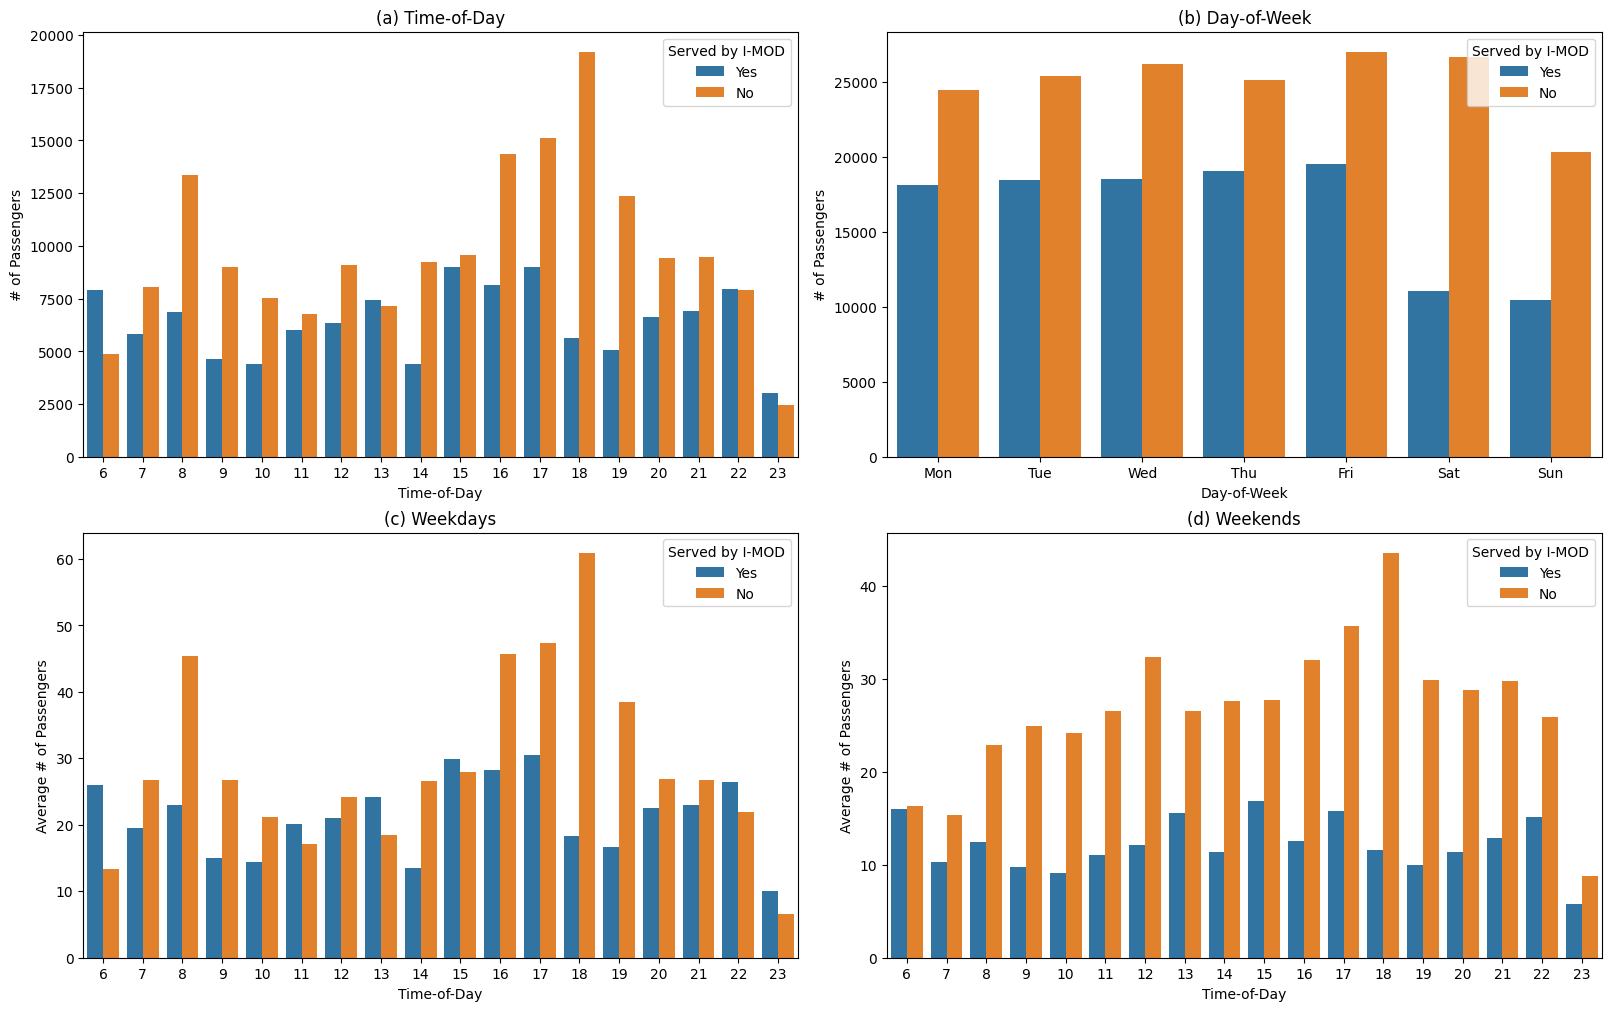

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
sns.barplot(data=demand.groupby(['Time-of-Day', 'Served by I-MOD'])['Npgrs'].sum().reset_index(), x='Time-of-Day', y='Npgrs', hue='Served by I-MOD', hue_order=['Yes', 'No'], ax=ax[0, 0])
sns.barplot(data=demand.groupby(['Day-of-Week', 'Served by I-MOD'])['Npgrs'].sum().reset_index(), x='Day-of-Week', y='Npgrs', hue='Served by I-MOD', order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], hue_order=['Yes', 'No'], ax=ax[0, 1])
sns.barplot(data=time_variation.loc[time_variation['Weekend'] == 'Weekday', :], x='Time-of-Day', y='Npgrs', hue='Served by I-MOD', hue_order=['Yes', 'No'], ax=ax[1, 0])
sns.barplot(data=time_variation.loc[time_variation['Weekend'] == 'Weekend', :], x='Time-of-Day', y='Npgrs', hue='Served by I-MOD', hue_order=['Yes', 'No'], ax=ax[1, 1])

ax[0, 0].set_title('(a) Time-of-Day', fontsize=12)
ax[0, 1].set_title('(b) Day-of-Week', fontsize=12)
ax[1, 0].set_title('(c) Weekdays', fontsize=12)
ax[1, 1].set_title('(d) Weekends', fontsize=12)

ax[0, 0].set_ylabel('# of Passengers', fontsize=10)
ax[0, 1].set_ylabel('# of Passengers', fontsize=10)
ax[1, 0].set_ylabel('Average # of Passengers', fontsize=10)
ax[1, 1].set_ylabel('Average # of Passengers', fontsize=10)

### 2.3. Converting Matrix

In [59]:
demand = demand.groupby(['Calltime', 'Boarding', 'Alighting'])['Npgrs'].sum().reset_index()
demand = demand.loc[demand['Calltime'] >= '2021-07-25', :]

In [60]:
demand['Boarding'] = demand['Boarding'].replace(station_yj['id'].to_list(), station_yj['h8'].to_list())
demand['Alighting'] = demand['Alighting'].replace(station_yj['id'].to_list(), station_yj['h8'].to_list())
demand = demand.groupby(['Calltime', 'Boarding', 'Alighting']).sum().reset_index()
demand

,Calltime,Boarding,Alighting,Npgrs
0,2021-07-25 06:00:00,8830e08c81fffff,8830e0b9c5fffff,1
1,2021-07-25 06:00:00,8830e08c91fffff,8830e08d8bfffff,1
2,2021-07-25 06:00:00,8830e08c91fffff,8830e08dc3fffff,1
3,2021-07-25 06:00:00,8830e08c93fffff,8830e08d8bfffff,1
4,2021-07-25 06:00:00,8830e08c97fffff,8830e08d8bfffff,1
...,...,...,...,...
222324,2022-07-02 23:00:00,8830e0b9c7fffff,8830e08c99fffff,1
222325,2022-07-02 23:00:00,8830e0b9e9fffff,8830e08c99fffff,1
222326,2022-07-02 23:00:00,8830e0bb37fffff,8830e0b913fffff,1
222327,2022-07-02 23:00:00,8830e0bb37fffff,8830e0b9c5fffff,1


In [61]:
duration = pd.period_range(start='2021-07-25 00:00', end='2022-07-02 23:00', freq='h') # Period
duration = duration[duration.hour >= 6] # Exclude 00:00 to 05:00
duration = pd.Series(duration).astype(str).astype('datetime64[ns]')
duration

0      2021-07-25 06:00:00
1      2021-07-25 07:00:00
2      2021-07-25 08:00:00
3      2021-07-25 09:00:00
4      2021-07-25 10:00:00
               ...        
6169   2022-07-02 19:00:00
6170   2022-07-02 20:00:00
6171   2022-07-02 21:00:00
6172   2022-07-02 22:00:00
6173   2022-07-02 23:00:00
Length: 6174, dtype: datetime64[ns]

In [62]:
temp_matrix = pd.DataFrame(0, index=station_yj['h8'].unique(), columns=station_yj['h8'].unique())
temp_matrix = temp_matrix.unstack().reset_index()
temp_matrix = temp_matrix.rename(columns={'level_0': 'Boarding', 'level_1': 'Alighting'})
temp_matrix.drop(columns=0, inplace=True)
temp_matrix

,Boarding,Alighting
0,8830e0b9e9fffff,8830e0b9e9fffff
1,8830e0b9e9fffff,8830e0b95dfffff
2,8830e0b9e9fffff,8830e08c9bfffff
3,8830e0b9e9fffff,8830e0b905fffff
4,8830e0b9e9fffff,8830e0b911fffff
...,...,...
8276,8830e08c01fffff,8830e0bb23fffff
8277,8830e08c01fffff,8830e0bb25fffff
8278,8830e08c01fffff,8830e0bb39fffff
8279,8830e08c01fffff,8830e0bb31fffff


In [63]:
data_matrix = pd.concat([temp_matrix] * len(duration), ignore_index=True)
data_matrix['Calltime'] = 0
data_matrix['Calltime'] = sorted(duration.to_list() * len(station_yj['h8'].unique()) * len(station_yj['h8'].unique()))
data_matrix = data_matrix.merge(demand, how='left', on=['Calltime', 'Boarding', 'Alighting']).fillna(0)
data_matrix = data_matrix.groupby(['Calltime', 'Boarding', 'Alighting'])['Npgrs'].sum().reset_index()
data_matrix.sort_values(by=['Calltime', 'Boarding', 'Alighting'], inplace=True, ignore_index=True)
data_matrix

,Calltime,Boarding,Alighting,Npgrs
0,2021-07-25 06:00:00,8830e08c01fffff,8830e08c01fffff,0.0
1,2021-07-25 06:00:00,8830e08c01fffff,8830e08c25fffff,0.0
2,2021-07-25 06:00:00,8830e08c01fffff,8830e08c27fffff,0.0
3,2021-07-25 06:00:00,8830e08c01fffff,8830e08c39fffff,0.0
4,2021-07-25 06:00:00,8830e08c01fffff,8830e08c81fffff,0.0
...,...,...,...,...
51126889,2022-07-02 23:00:00,8830e0bb3dfffff,8830e0bb31fffff,0.0
51126890,2022-07-02 23:00:00,8830e0bb3dfffff,8830e0bb35fffff,0.0
51126891,2022-07-02 23:00:00,8830e0bb3dfffff,8830e0bb37fffff,0.0
51126892,2022-07-02 23:00:00,8830e0bb3dfffff,8830e0bb39fffff,0.0


In [64]:
data_matrix['Npgrs'].describe()

count    5.112689e+07
mean     5.566874e-03
std      1.043682e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.300000e+01
Name: Npgrs, dtype: float64

In [65]:
data_matrix['Boarding'] = data_matrix['Boarding'].replace(h8_index, [i for i in range(len(h8_index))])
data_matrix['Alighting'] = data_matrix['Alighting'].replace(h8_index, [i for i in range(len(h8_index))])

<Axes: xlabel='hour'>

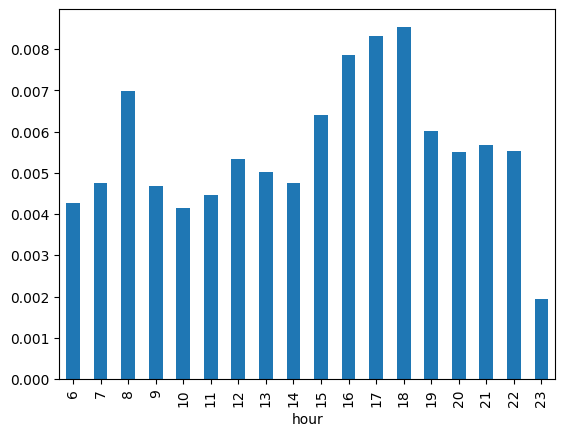

In [66]:
data_matrix['hour'] = data_matrix['Calltime'].dt.hour
data_matrix.groupby('hour')['Npgrs'].mean().plot(kind='bar')

In [67]:
ampeak = data_matrix.loc[data_matrix['hour'].isin([8]), :].groupby(['Boarding', 'Alighting'])['Npgrs'].mean().reset_index()
ampeak

,Boarding,Alighting,Npgrs
0,0,0,0.0
1,0,1,0.0
2,0,2,0.0
3,0,3,0.0
4,0,4,0.0
...,...,...,...
8276,90,86,0.0
8277,90,87,0.0
8278,90,88,0.0
8279,90,89,0.0


In [68]:
pmpeak = data_matrix.loc[data_matrix['hour'].isin([16, 17, 18]), :].groupby(['Boarding', 'Alighting'])['Npgrs'].mean().reset_index()
pmpeak

,Boarding,Alighting,Npgrs
0,0,0,0.000000
1,0,1,0.000000
2,0,2,0.000000
3,0,3,0.009718
4,0,4,0.000000
...,...,...,...
8276,90,86,0.000000
8277,90,87,0.000000
8278,90,88,0.001944
8279,90,89,0.000000


In [69]:
nonpeak = data_matrix.loc[data_matrix['hour'].isin([8, 16, 17, 18]) == False, :].groupby(['Boarding', 'Alighting'])['Npgrs'].mean().reset_index()
nonpeak

,Boarding,Alighting,Npgrs
0,0,0,0.000000
1,0,1,0.000000
2,0,2,0.000000
3,0,3,0.001458
4,0,4,0.000000
...,...,...,...
8276,90,86,0.000000
8277,90,87,0.000000
8278,90,88,0.000625
8279,90,89,0.000000


In [70]:
ampeak.to_csv('ampeak.csv', index=False)
pmpeak.to_csv('pmpeak.csv', index=False)
nonpeak.to_csv('nonpeak.csv', index=False)